# Explore and Finalize Feature Data

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [205]:
# Load data that has gone through preliminary prep (see prelim_data_processing.py).
prelim_df = pd.read_csv('./prelim_prepped_data.csv')
categorical_columns = ['educ_level', 'marital_status', 'occupation_name', 'race', 'sex', 'workclass', 'origin_c_income']
numerical_columns =['age', 'capital_gain', 'hours_week']


### Generate Summary Statistics

In [206]:
#Get summary stats for categorical columns
prelim_df.describe(include=np.object)

,educ_level,marital_status,occupation_name,race,sex,workclass,origin_c_income
count,48842,48842,46033,48842,48842,46043,47870
unique,10,7,14,5,2,8,5
top,hs_grad,Married-civ-spouse,Prof-specialty,White,Male,Private,US
freq,15784,22379,6172,41762,32650,33906,43832


In [207]:
print(f"""NOTE: Census data is overly white: {(len(prelim_df[prelim_df['race'] == 'White'])/len(prelim_df))*100}%, 
      and overly male: {(len(prelim_df[prelim_df['sex'] == 'Male'])/len(prelim_df))*100}% """)      
      

NOTE: Census data is overly white: 85.5042791040498%, 
      and overly male: 66.84820441423365% 


In [208]:
# Print frequency of outcome variable = 1 and outcome variable = 0
print(f"{(len(prelim_df[prelim_df['over_50k'] == 1])/len(prelim_df))*100}% of respondents make > 50k")

23.928176569346054% of respondents make > 50k


In [209]:
# Get summary stats for numeric columns
prelim_df.describe(include=np.number)

,age,capital_gain,hours_week,over_50k
count,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,991.565313,40.422382,0.239282
std,13.710510,7475.549906,12.391444,0.426649
min,17.000000,-4356.000000,1.000000,0.000000
25%,28.000000,0.000000,40.000000,0.000000
50%,37.000000,0.000000,40.000000,0.000000
75%,48.000000,0.000000,45.000000,0.000000
max,90.000000,99999.000000,99.000000,1.000000


In [210]:
# Strange concentration of $99,9999 values in capital_gains column. Check to see if other, nearby values present.
gain_counts = prelim_df['capital_gain'].value_counts().rename_axis('unique_values').reset_index(name='counts')
gain_counts.sort_values(by='unique_values')

,unique_values,counts
182,-4356,3
189,-3900,2
165,-3770,4
195,-3683,2
194,-3175,2
...,...,...
89,25236,14
23,27828,58
142,34095,6
185,41310,3


In [211]:
# 244 $999999 values and next closest value = $41,310 (freq=3). Appears 99999 may be placeholder for
# unknown, or all capital gains > 5 digits in length. Uncomment code below to mark as unknown; for now assuming
# 99999 is placeholder for gains > 5 digits in length.

#prelim_df['capital_gain'] = prelim_df['capital_gain'].replace({99999:np.nan})

### Analyze missing values

In [212]:
# 8 Percent of all rows have a null feature value.
percentage_null = ((prelim_df.drop(columns='over_50k').isnull().any(axis=1).value_counts()) / len(prelim_df)) *100
percentage_null

False    92.381557
True      7.618443
dtype: float64

In [213]:
# But no rows have a null outcome variable (over 50k)
percentage_outcomevar_null = ((prelim_df.isnull().over_50k.value_counts()) / len(prelim_df)) *100
percentage_outcomevar_null

False    100.0
Name: over_50k, dtype: float64

In [214]:
# Nearly 10% of records contain a null value, should impute values rather than drop all observations.
# See how many rows have multiple missing values. 
for number_missing in list(range(0,11)):
    percent_dropped = ((len(prelim_df) - len(prelim_df.dropna(thresh=11-number_missing, axis=0)))/len(prelim_df))*100
    print(f'Constraint: {number_missing} or more missing \t Percentage dropped: {percent_dropped}')


Constraint: 0 or more missing 	 Percentage dropped: 7.61844314319643
Constraint: 1 or more missing 	 Percentage dropped: 5.7307235575938735
Constraint: 2 or more missing 	 Percentage dropped: 0.12284509233856107
Constraint: 3 or more missing 	 Percentage dropped: 0.0
Constraint: 4 or more missing 	 Percentage dropped: 0.0
Constraint: 5 or more missing 	 Percentage dropped: 0.0
Constraint: 6 or more missing 	 Percentage dropped: 0.0
Constraint: 7 or more missing 	 Percentage dropped: 0.0
Constraint: 8 or more missing 	 Percentage dropped: 0.0
Constraint: 9 or more missing 	 Percentage dropped: 0.0
Constraint: 10 or more missing 	 Percentage dropped: 0.0


In [215]:
#If we drop only rows with > 2 values missing, only drop 0.12% of our dataset. Likely can afford this loss in power.
prelim_df = prelim_df.dropna(thresh=9, axis=0)

#For numerical values, fill in nulls with mean. For categorical, fill in with the mode.
prelim_df[numerical_columns] = prelim_df[numerical_columns].fillna(prelim_df.median().iloc[0])
prelim_df[categorical_columns] = prelim_df[categorical_columns].fillna(prelim_df.mode().iloc[0])

In [216]:
# Make categorical variables into dummies; Export final dataset for use in model classification
prepped_df = pd.get_dummies(prepped_df, prefix=categorical_columns, columns=categorical_columns, drop_first=True)
prepped_df.to_csv('./datasets/fully_prepped.csv')

### Analyze Numeric Features

In [217]:
# Create function to output mean of each variable, correlation with outcome variable, and box plot of each variable
def analyze_num_feature(num_feature):
    plt.boxplot(prepped_df[num_feature])
    plt.title(f"Box Plot of {num_feature.title()}")
    plt.ylim([prepped_df[num_feature].min()-0.05*(prepped_df[num_feature].min()), prepped_df[num_feature].max()+0.05*(prepped_df[num_feature].max())])
    plt.show()

    feature_mean = prepped_df[num_feature].mean()
    feature_corr = prepped_df[num_feature].corr(prepped_df['over_50k'])
    print(f"Mean: {feature_mean}\nCorrelation w/ over_50k: {feature_corr}")



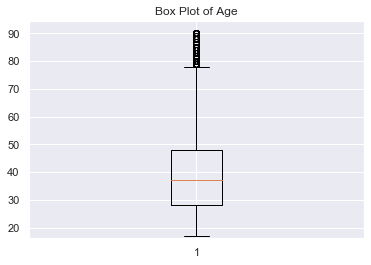

Mean: 38.64913287688082
Correlation w/ over_50k: 0.230469489976963


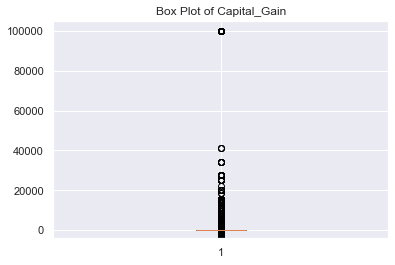

Mean: 990.5304415563118
Correlation w/ over_50k: 0.2142758981500935


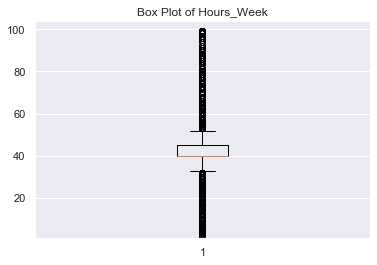

Mean: 40.43347956213358
Correlation w/ over_50k: 0.227620019313461


In [218]:
for feature in numerical_columns:
    analyze_num_feature(feature)